# *lenstronomy* starting guide

With this notebook, we describe the basic functionalities of the most important modules of *lenstronomy* with some simple examples. More detailed information about the available routines and their use can be accessed through the online documentation and in other jupyter notebooks.

In [1]:
# some standard python imports #
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

## $\texttt{LensModel}$ module
$\texttt{LensModel}$ and its sub-packages execute all the purely lensing related tasks of *lenstronomy*. This includes ray-shooting, solving the lens equation, arrival time computation and non-linear solvers to optimize lens models for specific image configurations. The module allows consistent integration with single and multi plane lensing and an arbitrary superpositions of lens models. There is a wide range of lens models available. For details we refer to to the online-documentation.

### Single plane lensing
As an example of initializing a single plane lens model as a super-position of an elliptical power-law potential and a singular isothermal sphere mass distribution and execute some basic routines:

In [2]:
# import the LensModel class #
from lenstronomy.LensModel.lens_model import LensModel

# specify the choice of lens models #
lens_model_list = ['SPEP', 'SHEAR', 'SIS']

# setup lens model class with the list of lens models #
lensModel = LensModel(lens_model_list=lens_model_list)

# define parameter values of lens models #
kwargs_spep = {'theta_E': 1., 'q': 0.9, 'phi_G': 0.5, 'gamma': 2., 'center_x': 0.1, 'center_y': 0}
kwargs_shear = {'e1': 0.01, 'e2': 0.0}
kwargs_sis2 = {'theta_E': 0.2, 'center_x': 1., 'center_y': -0.1}
kwargs_lens = [kwargs_spep, kwargs_shear, kwargs_sis2]

# image plane coordinate #
theta_ra, theta_dec = 1.4, .3

# source plane coordinate #
beta_ra, beta_dec = lensModel.ray_shooting(theta_ra, theta_dec, kwargs_lens)
# Fermat potential #
fermat_pot = lensModel.fermat_potential(x_image=theta_ra, y_image=theta_dec, x_source=beta_ra, y_source=beta_dec, kwargs_lens=kwargs_lens)

# Magnification #
mag = lensModel.magnification(theta_ra, theta_dec, kwargs_lens)

Additionally, the $\texttt{LensModel}$ class allows to compute the Hessian matrix, shear and convergence, deflection angle and lensing potential. These routines are fully compatible with the numpy array structure and as a superposition of an arbitrary number of single lens models.

### Multi-plane lensing

The multi-plane setting of $\texttt{LensModel}$ allows to place the different deflector models at different redshfits. When not further specified, the default cosmology of the $\texttt{astropy}$ cosmology class. The interface to access the lensing functionalities remains the same:

In [3]:
# import the LensModel class #
from lenstronomy.LensModel.lens_model import LensModel
# specify redshifts of deflectors #
redshift_list = [0.5, 0.5,.1]
# specify source redshift #
z_source = 1.5
# setup lens model class with the list of lens models #
lensModel_mp = LensModel(lens_model_list=lens_model_list, z_source=z_source, redshift_list=redshift_list, multi_plane=True)

# arrival time relative to a straight path through (0,0) #
dt = lensModel_mp.arrival_time(theta_ra, theta_dec, kwargs_lens)


### lens equation solver

Solving the lens equation to compute the (multiple) image positions of a given source position can be conveniently performed within $\texttt{LensModel}$ and is supported with a general instance of the $\texttt{LensModel}$ class.

In [4]:
# keep lensModel class and kwargs_lens from above #
# import the lens equation solver class #
from lenstronomy.LensModel.Solver.lens_equation_solver import LensEquationSolver

# specifiy the lens model class to deal with #
solver = LensEquationSolver(lensModel)

# solve for image positions provided a lens model and the source position #
theta_ra, theta_dec = solver.image_position_from_source(beta_ra, beta_dec, kwargs_lens)

# the magnification of the point source images #
mag = lensModel.magnification(theta_ra, theta_dec, kwargs_lens)

### illustration of lens models
The lens models can be conveniently illustrated with routines present in the $\texttt{Plot}$ module.

/Users/sibirrer/Cosmology/Software/lenstronomy/lenstronomy/Plots/output_plots.py:126: RuntimeWarning: invalid value encountered in log10
  im = ax.matshow(np.log10(kappa_result), origin='lower',
/Users/sibirrer/Library/Python/2.7/lib/python/site-packages/matplotlib/figure.py:403: UserWarning: matplotlib is currently using a non-GUI backend, so cannot show the figure
  "matplotlib is currently using a non-GUI backend, "


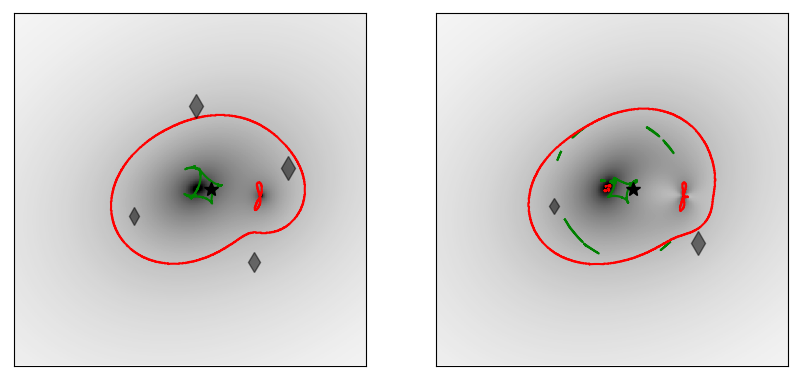

In [5]:
import lenstronomy.Plots.output_plots as lens_plot
f, axex = plt.subplots(1, 2, figsize=(10, 5), sharex=False, sharey=False)
lens_plot.lens_model_plot(axex[0], lensModel=lensModel, kwargs_lens=kwargs_lens, sourcePos_x=beta_ra, sourcePos_y=beta_dec, point_source=True)
#plt.savefig('/Users/sibirrer/Cosmology/Strong_Lensing/Papers/Lenstronomy/LenstronomyPaper/lens_model.pdf', format='pdf')
lens_plot.lens_model_plot(axex[1], lensModel=lensModel_mp, kwargs_lens=kwargs_lens, sourcePos_x=beta_ra, sourcePos_y=beta_dec, point_source=True)
f.show()

## $\texttt{LightModel}$ module

The $\texttt{LightModel}$ class provides the functionality to describe galaxy surface brightnesses. $\texttt{LightModel}$ supports various analytic profiles as well as representations in shapelet basis sets. Any superposition of different profiles is allowed.

In [6]:
# import the LightModel class #
from lenstronomy.LightModel.light_model import LightModel
# set up the list of light models to be used #
source_light_model_list = ['SERSIC']
lightModel_source = LightModel(light_model_list=source_light_model_list)
lens_light_model_list = ['SERSIC_ELLIPSE']
lightModel_lens = LightModel(light_model_list=lens_light_model_list)
# define the parameters #
kwargs_light_source = [{'I0_sersic': 10, 'R_sersic': 0.02, 'n_sersic': 1.5, 'center_x': beta_ra, 'center_y': beta_dec}]
kwargs_light_lens = [{'I0_sersic': 1000, 'R_sersic': 0.05, 'n_sersic': 2.5, 'q': 0.7, 'phi_G': 0.5, 'center_x': 0.1, 'center_y': 0}]

# evaluate surface brightness at a specific position #
flux = lightModel_lens.surface_brightness(x=1, y=1, kwargs_list=kwargs_light_lens)

## $\texttt{PointSource}$ module
To accurately predict and model the positon and flux of point sources, one has to apply different numerical procedures than for extended surface brightness features. The $\texttt{PointSource}$ class manages the different options in describing point sources (e.g. in the image plane or source plane, with fixed magnification or allowed with individual variations thereof) and provides a homogeneous interface to access image positions and magnifications.

In [7]:
# import the PointSource class #
from lenstronomy.PointSource.point_source import PointSource

# unlensed source positon
point_source_model_list = ['SOURCE_POSITION']
pointSource = PointSource(point_source_type_list=point_source_model_list, lensModel=lensModel, fixed_magnification_list=[True])
kwargs_ps = [{'ra_source': beta_ra, 'dec_source': beta_dec, 'source_amp': 100}]
# return image positions and amplitudes #
x_pos, y_pos = pointSource.image_position(kwargs_ps=kwargs_ps, kwargs_lens=kwargs_lens)
point_amp = pointSource.image_amplitude(kwargs_ps=kwargs_ps, kwargs_lens=kwargs_lens)

# lensed image positions (solution of the lens equation) #
point_source_model_list = ['LENSED_POSITION']
pointSource = PointSource(point_source_type_list=point_source_model_list, lensModel=lensModel, fixed_magnification_list=[False])
kwargs_ps = [{'ra_image': theta_ra, 'dec_image': theta_dec, 'point_amp': np.abs(mag)*30}]
# return image positions and amplitudes #
x_pos, y_pos = pointSource.image_position(kwargs_ps=kwargs_ps, kwargs_lens=kwargs_lens)
point_amp = pointSource.image_amplitude(kwargs_ps=kwargs_ps, kwargs_lens=kwargs_lens)

## $\texttt{Data}$ module
The $\texttt{Data}$ class stores and manages all the imaging data relevant information. This includes the coordinate frame, coordinate-to-pixel transformation (and the inverse), and in case of fitting also noise properties for likelihood estimates. The $\texttt{PSF}$ class handles the point spread function convolution. Supported are pixelized convolution kernels as well as some analytic profiles.

In [8]:
# import the Data() class #
from lenstronomy.Data.imaging_data import Data
deltaPix = 0.05  # size of pixel in angular coordinates #

# setup the keyword arguments to create the Data() class #
kwargs_data = {'numPix': 100,
    'ra_at_xy_0': -2.5,
    'dec_at_xy_0': -2.5, 
    'transform_pix2angle': np.array([[1, 0], [0, 1]]) * deltaPix}
data = Data(kwargs_data)
# return the list of pixel coordinates #
x_coords, y_coords = data.coordinates
# compute pixel value of a coordinate position #
x_pos, y_pos = data.map_coord2pix(ra=0, dec=0)
# compute the coordinate value of a pixel position #
ra_pos, dec_pos = data.map_pix2coord(x=20, y=10)

# import the PSF() class #
from lenstronomy.Data.psf import PSF
kwargs_psf = {'psf_type': 'GAUSSIAN', 'fwhm': 0.1, 'pixel_size': deltaPix}
psf = PSF(kwargs_psf)
# return the pixel kernel corresponding to a point source # 
kernel = psf.kernel_point_source

## $\texttt{ImSim}$ module
The $\texttt{ImSim}$ module simulates images. At its core is the $\texttt{ImageModel}$ class. It is the interface to combine all the different components, $\texttt{LensModel}$, $\texttt{LightModel}$, $\texttt{PointSource}$ and $\texttt{Data}$ to model images. The $\texttt{LightModel}$ can be used to model lens light (unlensed) or source light (lensed). $\texttt{ImSim}$ is fully supporting all functionalities in each component. Additionaly, numerical precision arguments can be set in how to model the image.

### Simulate image
We simulate an image with an instance of $\texttt{ImageModel}$ that got instances of the classes we created above. We can define two different $\texttt{LightModel}$ instances for the lens and source light. Additionally, we can define the sub-pixel ray-tracing resolution and whether the PSF convolution is applied on the higher resolution ray-tracing image or on the degraded pixel image.

In [9]:
# import the ImageModel class #
from lenstronomy.ImSim.image_model import ImageModel
# define the numerics #
kwargs_numerics = {'subgrid_res': 3,
                  'psf_subgrid': True}
# initialize the Image model class by combining the modules we created above #
imageModel = ImageModel(data_class=data, psf_class=psf, lens_model_class=lensModel,
                        source_model_class=lightModel_source,
                        lens_light_model_class=lightModel_lens,
                        point_source_class=pointSource, 
                        kwargs_numerics=kwargs_numerics)
# simulate image with the parameters we have defined above #
image = imageModel.image(kwargs_lens=kwargs_lens, kwargs_source=kwargs_light_source,
                         kwargs_lens_light=kwargs_light_lens, kwargs_ps=kwargs_ps)

# we can also add noise #
import lenstronomy.Util.image_util as image_util
exp_time = 100  # exposure time to quantify the Poisson noise level
sigma_bkg = 0.1  # background rms value
poisson = image_util.add_poisson(image, exp_time=exp_time)
bkg = image_util.add_background(image, sigma_bkd=sigma_bkg)
image_noisy = image + bkg + poisson

### Linear inversion
Parameter corresponding to an an amplitude of a surface brightness distribution have a linear response on the predicted flux values in the data and can be extracted in a linear inversion. This can reduce the number of non-linear parameters fastly, depending on the source complexity to be modelled. In the example of this notebook, we have 6 linear parameters, the 4 point source amplitudes and the amplitudes of the Sersic profile of the lens and source. *lenstronomy* automatically identify those parameters and can recover those values (data permitting).


In [10]:
# update the data with the noisy image and its noise properties #
kwargs_data['image_data'] = image_noisy
kwargs_data['background_rms'] = sigma_bkg
kwargs_data['exposure_map'] = np.ones_like(image_noisy)* exp_time
data_class_sim = Data(kwargs_data)
imageModel.update_data(data_class_sim)

# we do not require the knowledge of the linear parameters #
del kwargs_light_source[0]['I0_sersic']
# apply the linear inversion to fit for the noisy image #
image_reconstructed, _, _, _ = imageModel.image_linear_solve(kwargs_lens=kwargs_lens, kwargs_source=kwargs_light_source, 
                              kwargs_lens_light=kwargs_light_lens, kwargs_ps=kwargs_ps)

('reduced chi^^ = ', 0.94252839588666704)


/Users/sibirrer/Cosmology/Software/lenstronomy/lenstronomy/Plots/output_plots.py:220: RuntimeWarning: invalid value encountered in log10
  im = ax.matshow(np.log10(self._data), origin='lower',


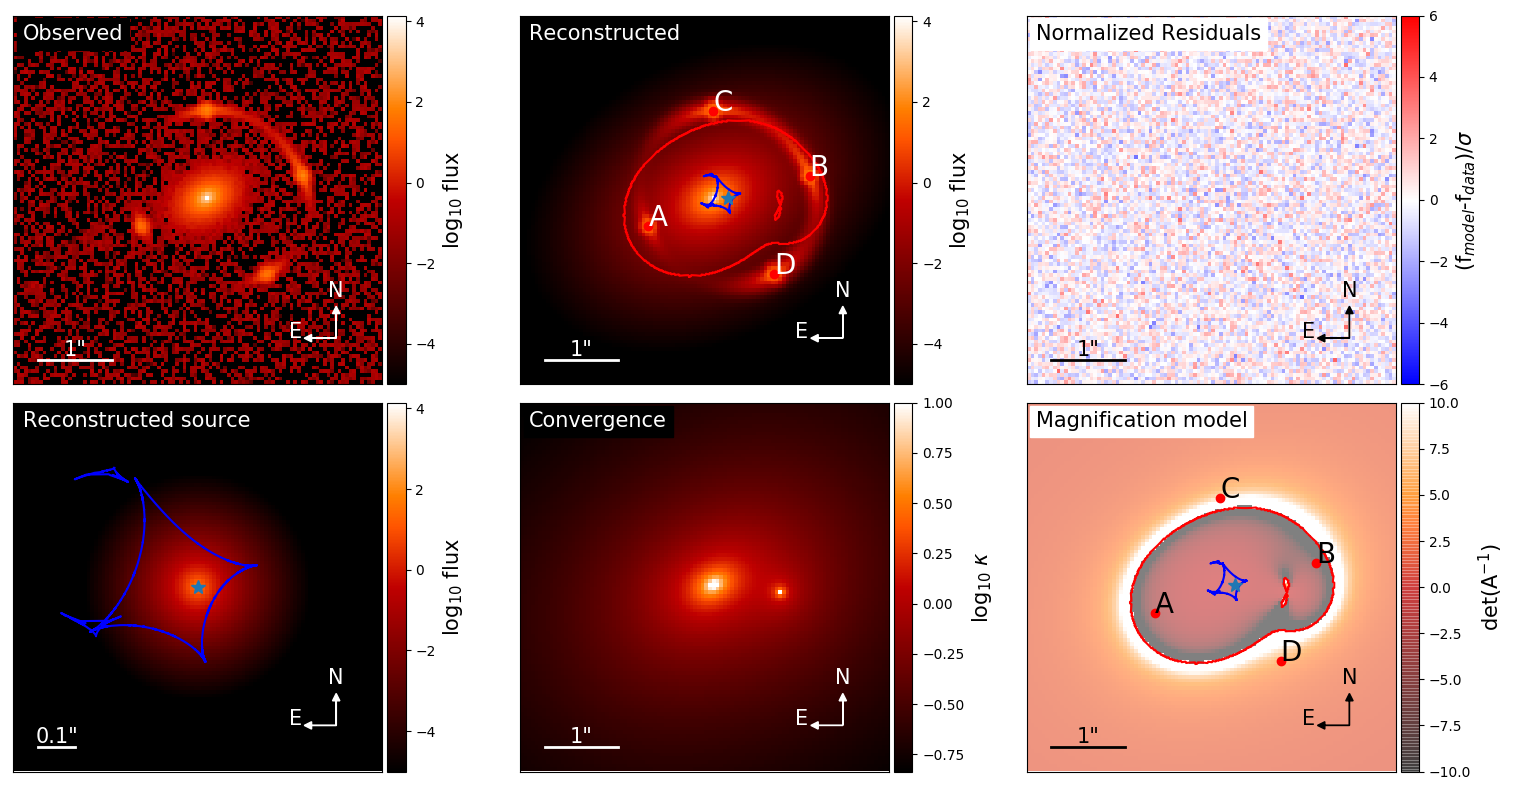

In [11]:
# illustrate fit
from lenstronomy.Plots.output_plots import LensModelPlot
kwargs_model = {'lens_model_list': lens_model_list, 'source_light_model_list': source_light_model_list,
               'lens_light_model_list': lens_light_model_list, 'point_source_model_list': point_source_model_list}
lensPlot = LensModelPlot(kwargs_data, kwargs_psf, kwargs_numerics, kwargs_model, kwargs_lens, kwargs_light_source,
                            kwargs_light_lens, kwargs_ps, arrow_size=0.02)
    
f, axes = plt.subplots(2, 3, figsize=(16, 8), sharex=False, sharey=False)
lensPlot.data_plot(ax=axes[0,0])
lensPlot.model_plot(ax=axes[0,1])
lensPlot.normalized_residual_plot(ax=axes[0,2], v_min=-6, v_max=6)
lensPlot.source_plot(ax=axes[1, 0],convolution=False, deltaPix_source=0.01, numPix=100)
lensPlot.convergence_plot(ax=axes[1, 1], v_max=1)
lensPlot.magnification_plot(ax=axes[1, 2])
f.tight_layout()
f.subplots_adjust(left=None, bottom=None, right=None, top=None, wspace=0., hspace=0.05)
plt.show()

## $\texttt{Workflow}$ Module
The $\texttt{Workflow}$ Module manages the execution of non-linear fitter (in our case the PSO) and the parameter inference (in our case the CosmoHammer emcee). The two main classes are $\texttt{Param}$ and $\texttt{FittingSequence}$. These classes handle all the model choices of the user and mitigate them to the external modules and from the external modules back to *lenstronomy*.

### $\texttt{Param}$ class
The $\texttt{Param}$ class is the interface of the *lenstronomy* conventions of parameters (list of keyword arguments) and the fitting conventions of $\texttt{CosmoHammer}$ or $\texttt{emcee}$ (single array consisting all parameters). The $\texttt{Param}$ class enables the user to set further options:

- keep certain parameters fixed
- handling of the linear parameters
- provide additional constraints on the modelling (e.g. fix source profile to point source position etc)

With the $\texttt{Param}$ class, lenstronomy can be integrated robustly with other sampling methods.

In [12]:
# import the parameter handling class #
from lenstronomy.Workflow.parameters import Param
# set options for constraint parameters #
kwargs_constraints = {'joint_center_lens_light': False,
                'joint_center_source_light': False,
                'num_point_source_list': [4],
                'additional_images_list': [False],
                'fix_to_point_source_list': [True],
                'image_plane_source_list': [False],
                'solver': True,
                'solver_type': 'PROFILE_SHEAR',  # 'PROFILE', 'PROFILE_SHEAR', 'ELLIPSE', 'CENTER'
               }
# list fixed parameters #
kwargs_fixed_lens = [{'gamma': 2.}, {}, {}]
kwargs_fixed_source = [{}]
kwargs_fixed_lens_light = [{}]
kwargs_fixed_ps = [{}]
kwargs_fixed = [kwargs_fixed_lens, kwargs_fixed_source, kwargs_fixed_lens_light, kwargs_fixed_ps]
# make instance of parameter class with given model options, constraints and fixed parameters #
param = Param(kwargs_model, kwargs_constraints, kwargs_fixed_lens, kwargs_fixed_source,
                 kwargs_fixed_lens_light, kwargs_fixed_ps, kwargs_lens_init=kwargs_lens)
# the number of non-linear parameters and their names #
num_param, param_list = param.num_param()
# parameter array for fitting routine #
param_array = param.setParams(kwargs_lens, kwargs_light_source, kwargs_light_lens, kwargs_ps)
print param_array
# recover keyword arguments list for lenstronomy from a parameter array of the fitting routine #
kwargs_lens_out, kwargs_light_source_out, kwargs_light_lens_out, kwargs_ps_out = param.getParams(param_array)




[0.01, 0.2, 1.0, -0.1, 1.5, 0.02, 0.1, 0, 2.5, 0.05, 0.095347465741436446, 0.14849487967198177, -0.78634022481055699, 1.4000000000000445, 0.096508251847524901, 0.91837032490144843, -0.38172564054123709, 0.29999999999992405, 1.1848723462565893, -1.0308556889710192]


### $\texttt{FittingSequence}$ class

The $\texttt{FittingSequence}$ class allows to perform a PSO and/or MCMC run. The user can run a sequence of fitting routines, applied one after the other with taking the results of the previous routine as an input of the next one. The user can specify (optionaly) to keep one or multiple parameter classes (lens model, source model, lens light model and source model) fixed during the fitting process or parameter inference.

The user further needs to specify:
- define input guess and uncertainties and uncertainties
- hard bounds on parameters
- number of particles and number of iterations being performed by the PSO/MCMC

$\texttt{FittingSequence}$ does not rely on instances of other *lenstronomy* classes. It can be constructed from elements in the form of keyword arguments and lists thereof in the *lenstronomy* conventions. This enables a save and reliable execution of tasks within $\texttt{FittingSequence}$ on non-local platforms, such as high performance clusters.

In [13]:
# initial guess of non-linear parameters, we chose different starting parameters than the truth #
kwargs_lens_init = [{'theta_E': 1.2, 'q': 1., 'phi_G': 0., 'gamma': 2., 'center_x': 0., 'center_y': 0},
    {'e1': 0.0, 'e2': 0.01}, {'theta_E': 0.1, 'center_x': 1., 'center_y': 0}]
kwargs_source_init = [{'R_sersic': 0.03, 'n_sersic': 1., 'center_x': 0, 'center_y': 0}]
kwargs_lens_light_init = [{'R_sersic': 0.1, 'n_sersic': 1, 'q': 1., 'phi_G': 0, 'center_x': 0, 'center_y': 0}]
kwargs_ps_init = [{'ra_image': theta_ra+0.01, 'dec_image': theta_dec-0.01}]
kwargs_init = [kwargs_lens_init, kwargs_source_init, kwargs_lens_light_init, kwargs_ps_init]

# initial spread in parameter estimation #
kwargs_lens_sigma = [{'theta_E_sigma': 0.3, 'ellipse_sigma': 0.2, 'gamma_sigma': .2, 'center_x_sigma': 0.1, 'center_y_sigma': 0.1},
    {'shear_sigma': 0.1}, {'theta_E_sigma': 0.1, 'center_x_sigma': .1, 'center_y_sigma': 0.1}]
kwargs_source_sigma = [{'R_sersic_sigma': 0.1, 'n_sersic_sigma': .5, 'center_x_sigma': .1, 'center_y_sigma': 0.1}]
kwargs_lens_light_sigma = [{'R_sersic_sigma': 0.1, 'n_sersic_sigma': 0.2, 'ellipse_sigma': 0.2, 'center_x_sigma': .1, 'center_y_sigma': 0.1}]
kwargs_ps_sigma = [{'pos_sigma': 0.02}]
kwargs_sigma = [kwargs_lens_sigma, kwargs_source_sigma, kwargs_lens_light_sigma, kwargs_ps_sigma]

# hard bound lower limit in parameter space #
kwargs_lower_lens = [{'theta_E': 0, 'q': .2, 'phi_G': 0., 'gamma': 1.5, 'center_x': -10., 'center_y': -10},
    {'e1': -.2, 'e2': -0.2}, {'theta_E': 0., 'center_x': -10, 'center_y': -10}]
kwargs_lower_source = [{'R_sersic': 0.001, 'n_sersic': .5, 'center_x': -10, 'center_y': -10}]
kwargs_lower_lens_light = [{'R_sersic': 0.001, 'n_sersic': 0.5, 'q': .1, 'phi_G': 0, 'center_x': -10, 'center_y': -10}]
kwargs_lower_ps = [{'ra_image': -10 * np.ones_like(theta_ra), 'dec_image': -10 * np.ones_like(theta_dec)}]
kwargs_lower = [kwargs_lower_lens, kwargs_lower_source, kwargs_lower_lens_light, kwargs_lower_ps]

# hard bound upper limit in parameter space #
kwargs_upper_lens = [{'theta_E': 10, 'q': .2, 'phi_G': 0., 'gamma': 2.5, 'center_x': 10., 'center_y': 10},
    {'e1': 0.2, 'e2': 0.2}, {'theta_E': 1., 'center_x': 10, 'center_y': 10}]
kwargs_upper_source = [{'R_sersic': 10, 'n_sersic': 5., 'center_x': 10, 'center_y': 10}]
kwargs_upper_lens_light = [{'R_sersic': 10, 'n_sersic': 5., 'q': .1, 'phi_G': 0, 'center_x': 10, 'center_y': 10}]
kwargs_upper_ps = [{'ra_image': 10 * np.ones_like(theta_ra), 'dec_image': 10 * np.ones_like(theta_dec)}]
kwargs_upper = [kwargs_upper_lens, kwargs_upper_source, kwargs_upper_lens_light, kwargs_upper_ps]

kwargs_params = [kwargs_init, kwargs_sigma, kwargs_fixed, kwargs_lower, kwargs_upper]


kwargs_likelihood = {'source_marg': False}

band_list = [kwargs_data, kwargs_psf, kwargs_numerics]
multi_band_list = []
multi_band_list.append(band_list)



from lenstronomy.Workflow.fitting_sequence import FittingSequence
fitting_seq = FittingSequence(multi_band_list, kwargs_model, kwargs_constraints, kwargs_likelihood, kwargs_params)

fitting_kwargs_list = [
        {'fitting_routine': 'PSO', 'mpi': False, 'sigma_scale': 1., 'n_particles': 200,
         'n_iterations': 200},
        {'fitting_routine': 'MCMC', 'n_burn': 10, 'n_run': 10, 'walkerRatio': 10, 'mpi': False,
         'sigma_scale': .1}]

lens_result, source_result, lens_light_result, ps_result, chain_list, param_list, samples_mcmc, param_mcmc, dist_mcmc = fitting_seq.fit_sequence(fitting_kwargs_list)

Computing the PSO ...


/Users/sibirrer/Library/Python/2.7/lib/python/site-packages/scipy/optimize/minpack.py:161: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last five Jacobian evaluations.
  warnings.warn(msg, RuntimeWarning)
/Users/sibirrer/Library/Python/2.7/lib/python/site-packages/scipy/optimize/minpack.py:161: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)


10
20
30
40
50
60
70
80
90
100
110
120
130
140
150
160
170
180
190
200
max iteration reached! stoping
(-1.0148490687612339, 'reduced X^2 of best position')
(9979, 'effective number of data points')
([{'theta_E': 1.0340901275421936, 'q': 0.8849027079085896, 'center_x': 0.1166920111030373, 'center_y': -0.0064639615482822536, 'phi_G': 0.49353925474145383, 'gamma': 2.0}, {'e1': 0.013754830527905977, 'e2': 0.01060370158286637}, {'center_y': -0.086862828547126694, 'center_x': 1.0866540607509023, 'theta_E': 0.16641387169052035}], 'lens result')
([{'n_sersic': 1.5499701522395943, 'center_x': 0.30260308172194972, 'center_y': -0.0036711513399632634, 'R_sersic': 0.021250578831017421, 'I0_sersic': 1}], 'source result')
([{'q': 0.70031574607073921, 'I0_sersic': 1, 'n_sersic': 2.5139968482285675, 'center_x': 0.099999552078519668, 'center_y': -3.633806396930944e-09, 'phi_G': 0.49879596465294995, 'R_sersic': 0.050003886798901276}], 'lens light result')
([{'point_amp': 1, 'ra_image': array([-0.78650694

/Users/sibirrer/Library/Python/2.7/lib/python/site-packages/emcee/ensemble.py:335: RuntimeWarning: invalid value encountered in subtract
  lnpdiff = (self.dim - 1.) * np.log(zz) + newlnprob - lnprob0
/Users/sibirrer/Library/Python/2.7/lib/python/site-packages/emcee/ensemble.py:336: RuntimeWarning: invalid value encountered in greater
  accept = (lnpdiff > np.log(self._random.rand(len(lnpdiff))))


InMemoryStorageUtil does not support storeRandomState
(124.41702795028687, 'time taken for MCMC sampling')


('reduced chi^^ = ', 0.95412705225216998)


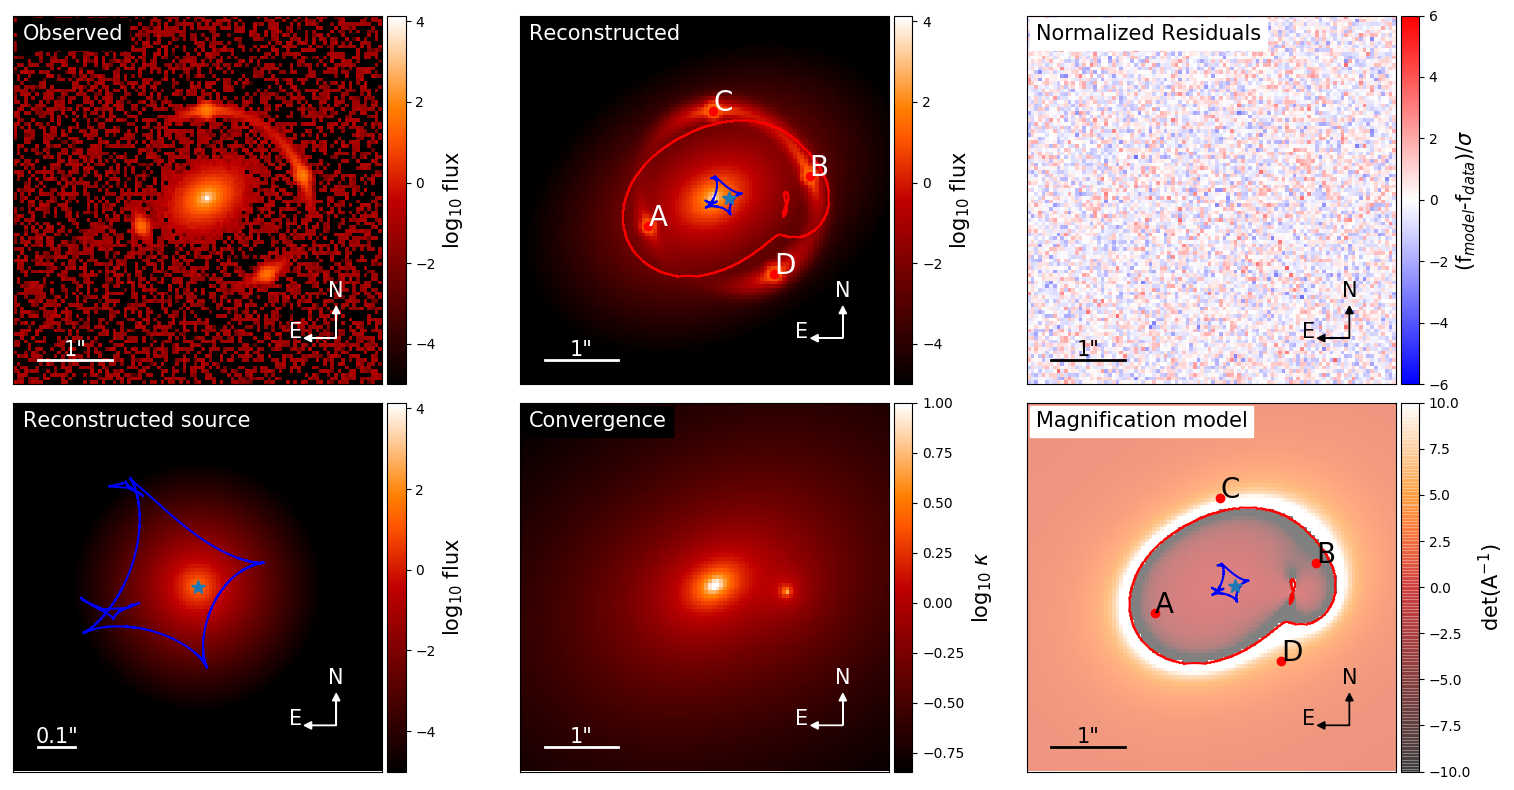

/Users/sibirrer/Cosmology/Software/lenstronomy/lenstronomy/Plots/output_plots.py:477: RuntimeWarning: divide by zero encountered in log10
  im = ax.matshow(np.log10(model), origin='lower', vmin=v_min, vmax=v_max,


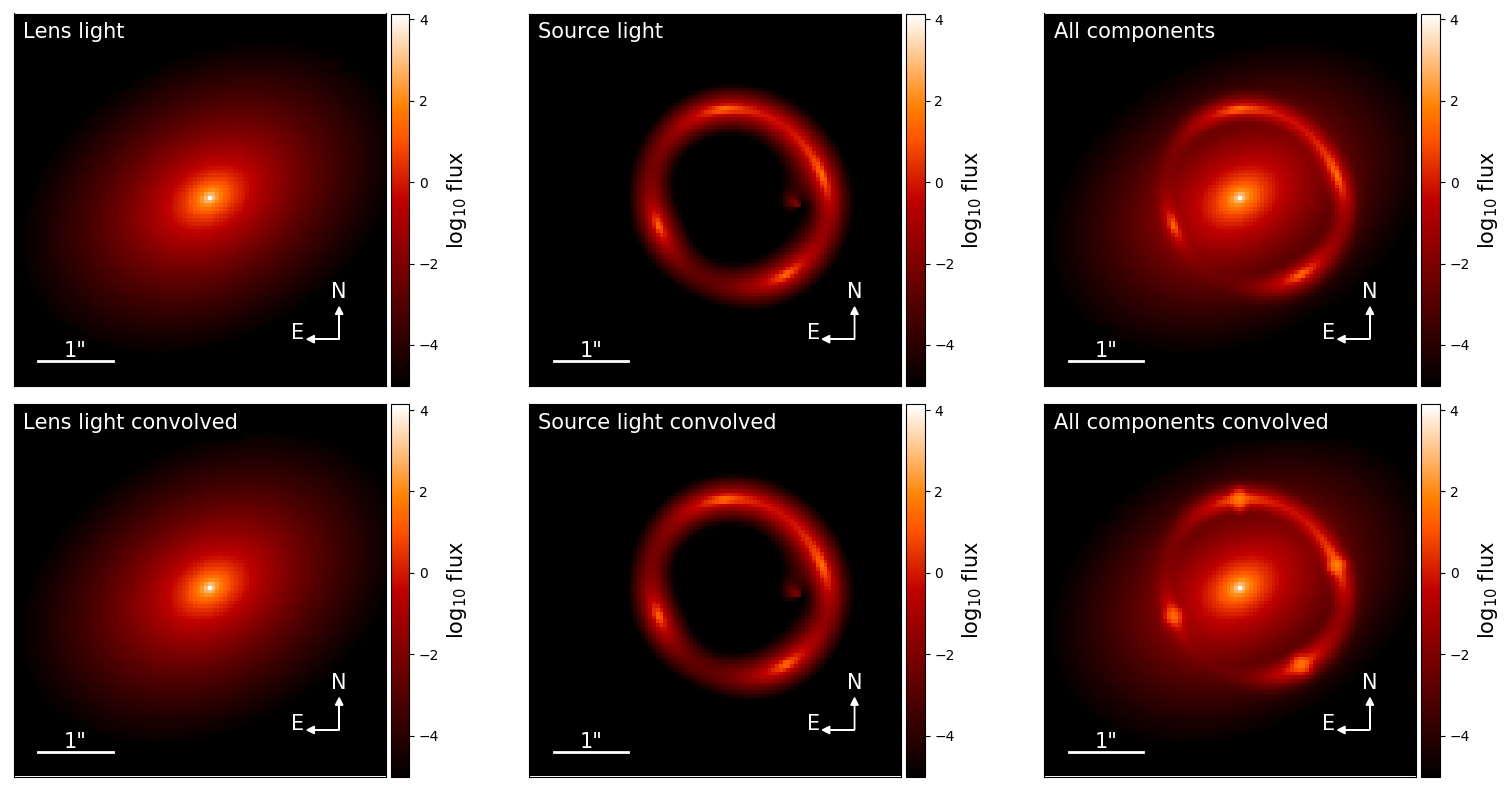

[{'theta_E': 1.0340901275421936, 'q': 0.8849027079085896, 'center_x': 0.1166920111030373, 'center_y': -0.0064639615482822536, 'phi_G': 0.49353925474145383, 'gamma': 2.0}, {'e1': 0.013754830527905977, 'e2': 0.01060370158286637}, {'center_y': -0.086862828547126694, 'center_x': 1.0866540607509023, 'theta_E': 0.16641387169052035}] [{'n_sersic': 1.5499701522395943, 'center_x': 0.30260308172194972, 'center_y': -0.0036711513399632634, 'R_sersic': 0.021250578831017421, 'I0_sersic': 9.6120197488809609}] [{'q': 0.70031574607073921, 'I0_sersic': 996.40590597743073, 'n_sersic': 2.5139968482285675, 'center_x': 0.099999552078519668, 'center_y': -3.633806396930944e-09, 'phi_G': 0.49879596465294995, 'R_sersic': 0.050003886798901276}] [{'point_amp': array([  97.14533815,  248.01866305,  234.47901683,  150.72668327]), 'ra_image': array([-0.78650694,  1.40006525,  0.09669856,  0.91994854]), 'dec_image': array([-0.3815555 ,  0.29950713,  1.184422  , -1.03071637])}]


In [14]:

lensPlot = LensModelPlot(kwargs_data, kwargs_psf, kwargs_numerics, kwargs_model, lens_result, source_result,
                             lens_light_result, ps_result, arrow_size=0.02, cmap_string="gist_heat", high_res=5)
    
f, axes = plt.subplots(2, 3, figsize=(16, 8), sharex=False, sharey=False)

lensPlot.data_plot(ax=axes[0,0])
lensPlot.model_plot(ax=axes[0,1])
lensPlot.normalized_residual_plot(ax=axes[0,2], v_min=-6, v_max=6)
lensPlot.source_plot(ax=axes[1, 0],convolution=False, deltaPix_source=0.01, numPix=100)
lensPlot.convergence_plot(ax=axes[1, 1], v_max=1)
lensPlot.magnification_plot(ax=axes[1, 2])
f.tight_layout()
f.subplots_adjust(left=None, bottom=None, right=None, top=None, wspace=0., hspace=0.05)
plt.show()

f, axes = plt.subplots(2, 3, figsize=(16, 8), sharex=False, sharey=False)

lensPlot.decomposition_plot(ax=axes[0,0], text='Lens light', lens_light_add=True, unconvolved=True)
lensPlot.decomposition_plot(ax=axes[1,0], text='Lens light convolved', lens_light_add=True)
lensPlot.decomposition_plot(ax=axes[0,1], text='Source light', source_add=True, unconvolved=True)
lensPlot.decomposition_plot(ax=axes[1,1], text='Source light convolved', source_add=True)
lensPlot.decomposition_plot(ax=axes[0,2], text='All components', source_add=True, lens_light_add=True, unconvolved=True)
lensPlot.decomposition_plot(ax=axes[1,2], text='All components convolved', source_add=True, lens_light_add=True, point_source_add=True)
f.tight_layout()
f.subplots_adjust(left=None, bottom=None, right=None, top=None, wspace=0., hspace=0.05)
plt.show()
print lens_result, source_result, lens_light_result, ps_result

number of non-linear parameters in the MCMC process:  20
parameters in order:  ['gamma_ext', 'theta_E', 'center_x_lens', 'center_y_lens', 'n_sersic_source_light', 'R_sersic_source_light', 'center_x_lens_light', 'center_y_lens_light', 'n_sersic_lens_light', 'R_sersic_lens_light', 'e1_lens_light', 'e2_lens_light', 'ra_image', 'ra_image', 'ra_image', 'ra_image', 'dec_image', 'dec_image', 'dec_image', 'dec_image']
number of evaluations in the MCMC process:  2000


/Users/sibirrer/Library/Python/2.7/lib/python/site-packages/ipykernel/__main__.py:5: DeprecationWarning: elementwise == comparison failed; this will raise an error in the future.


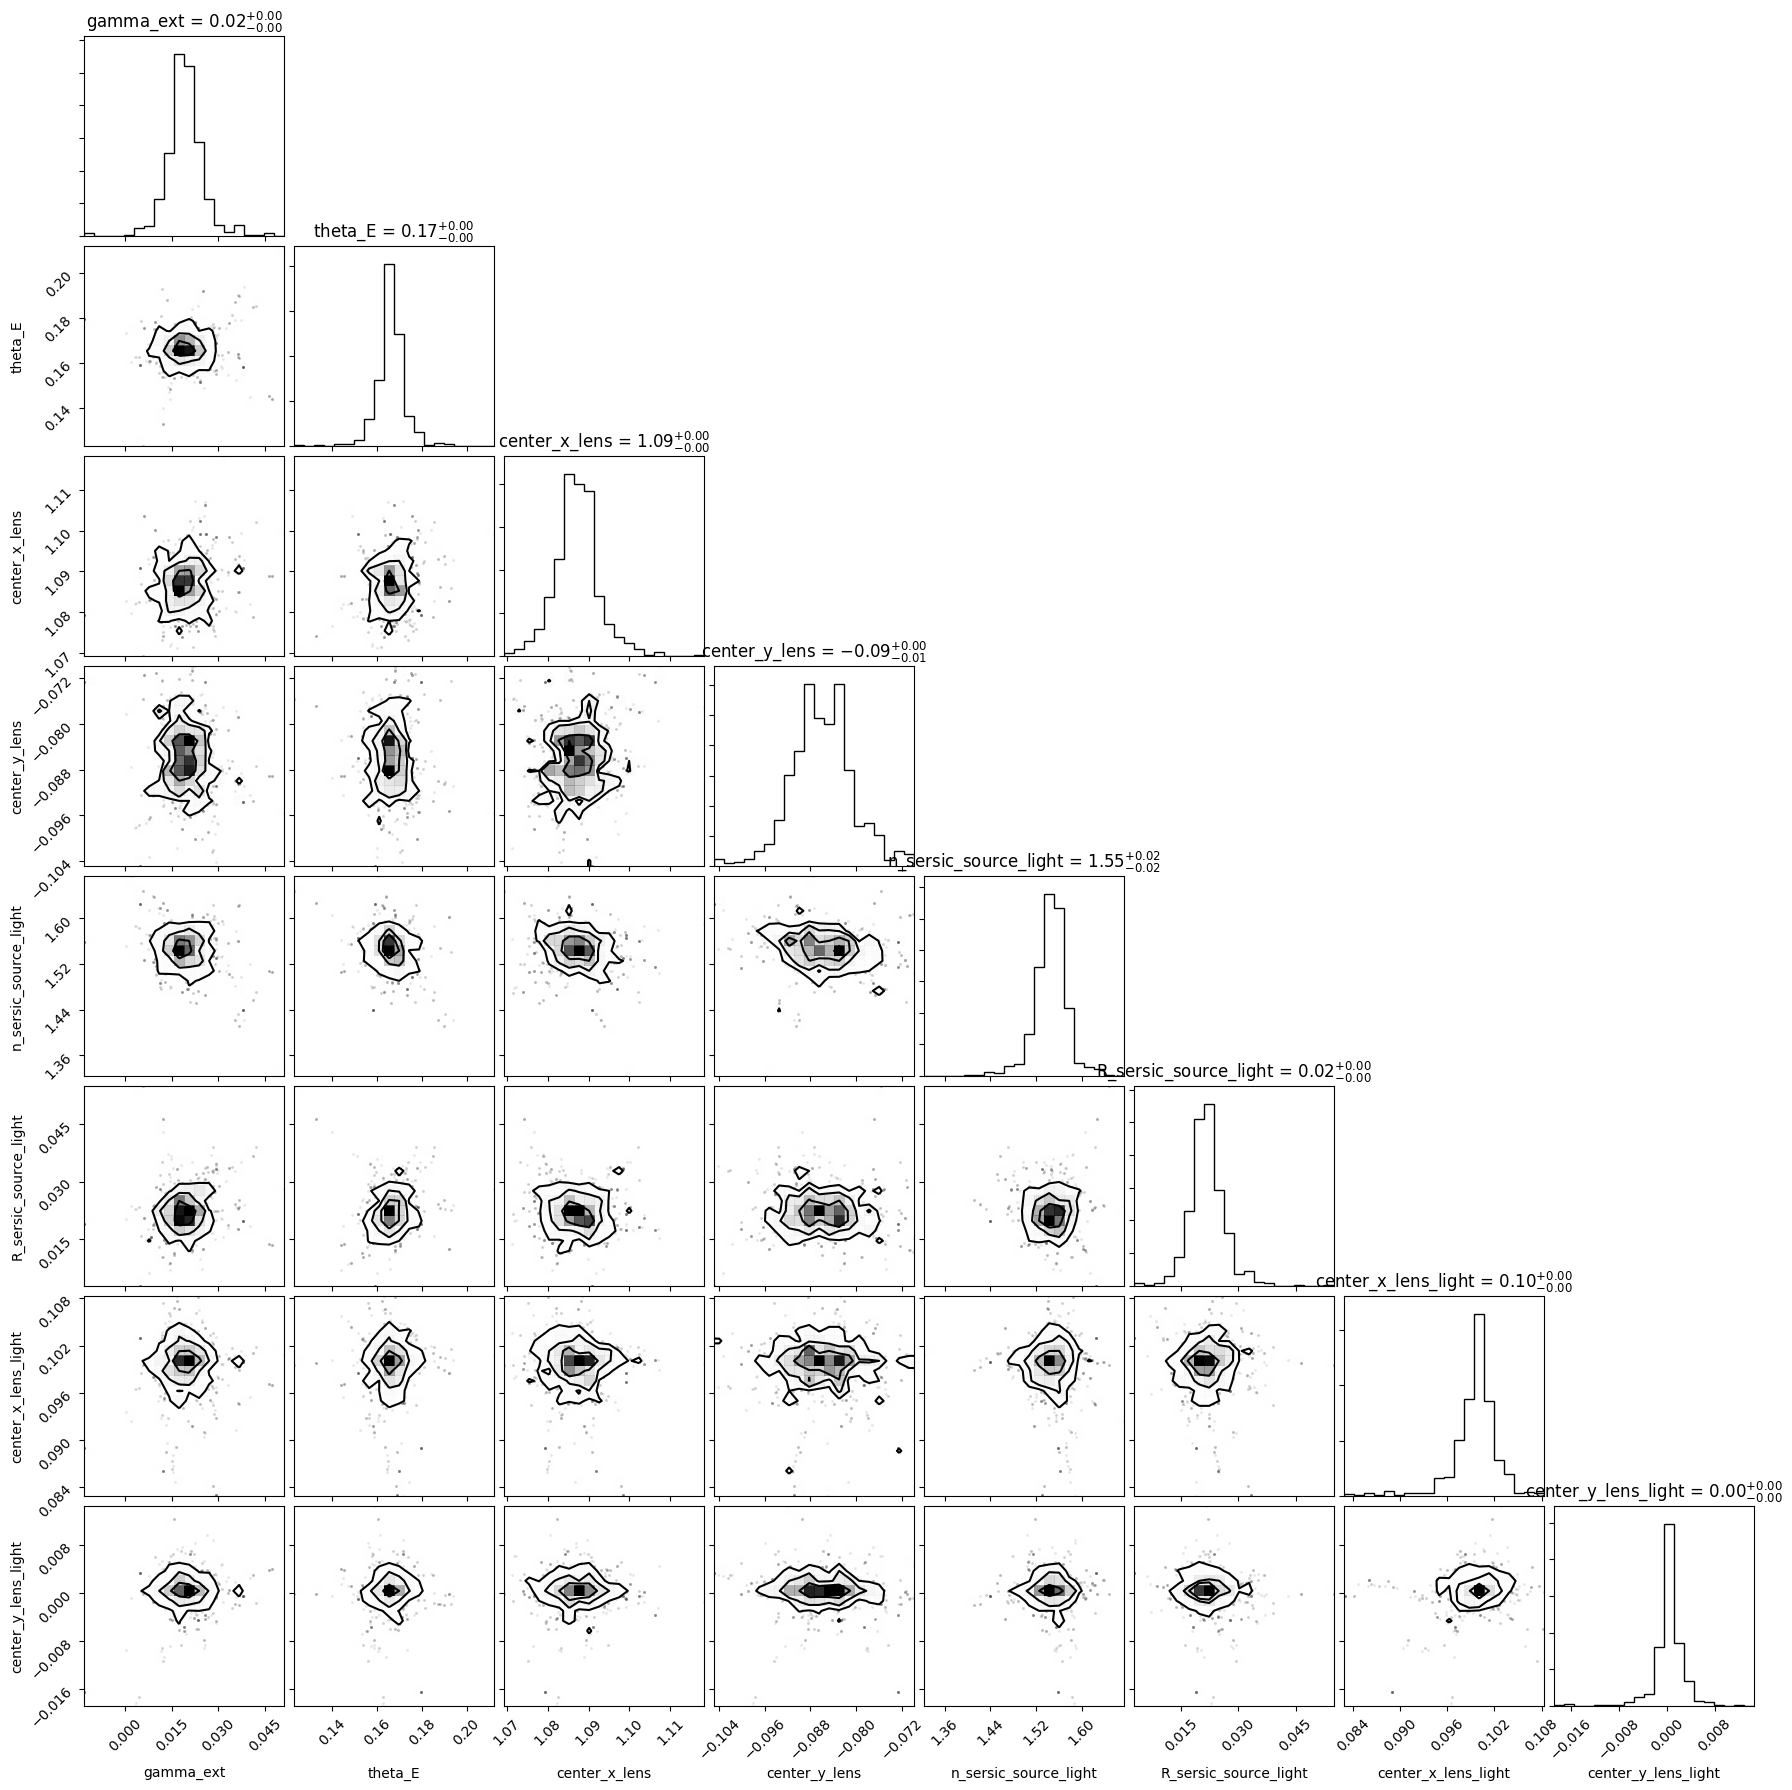

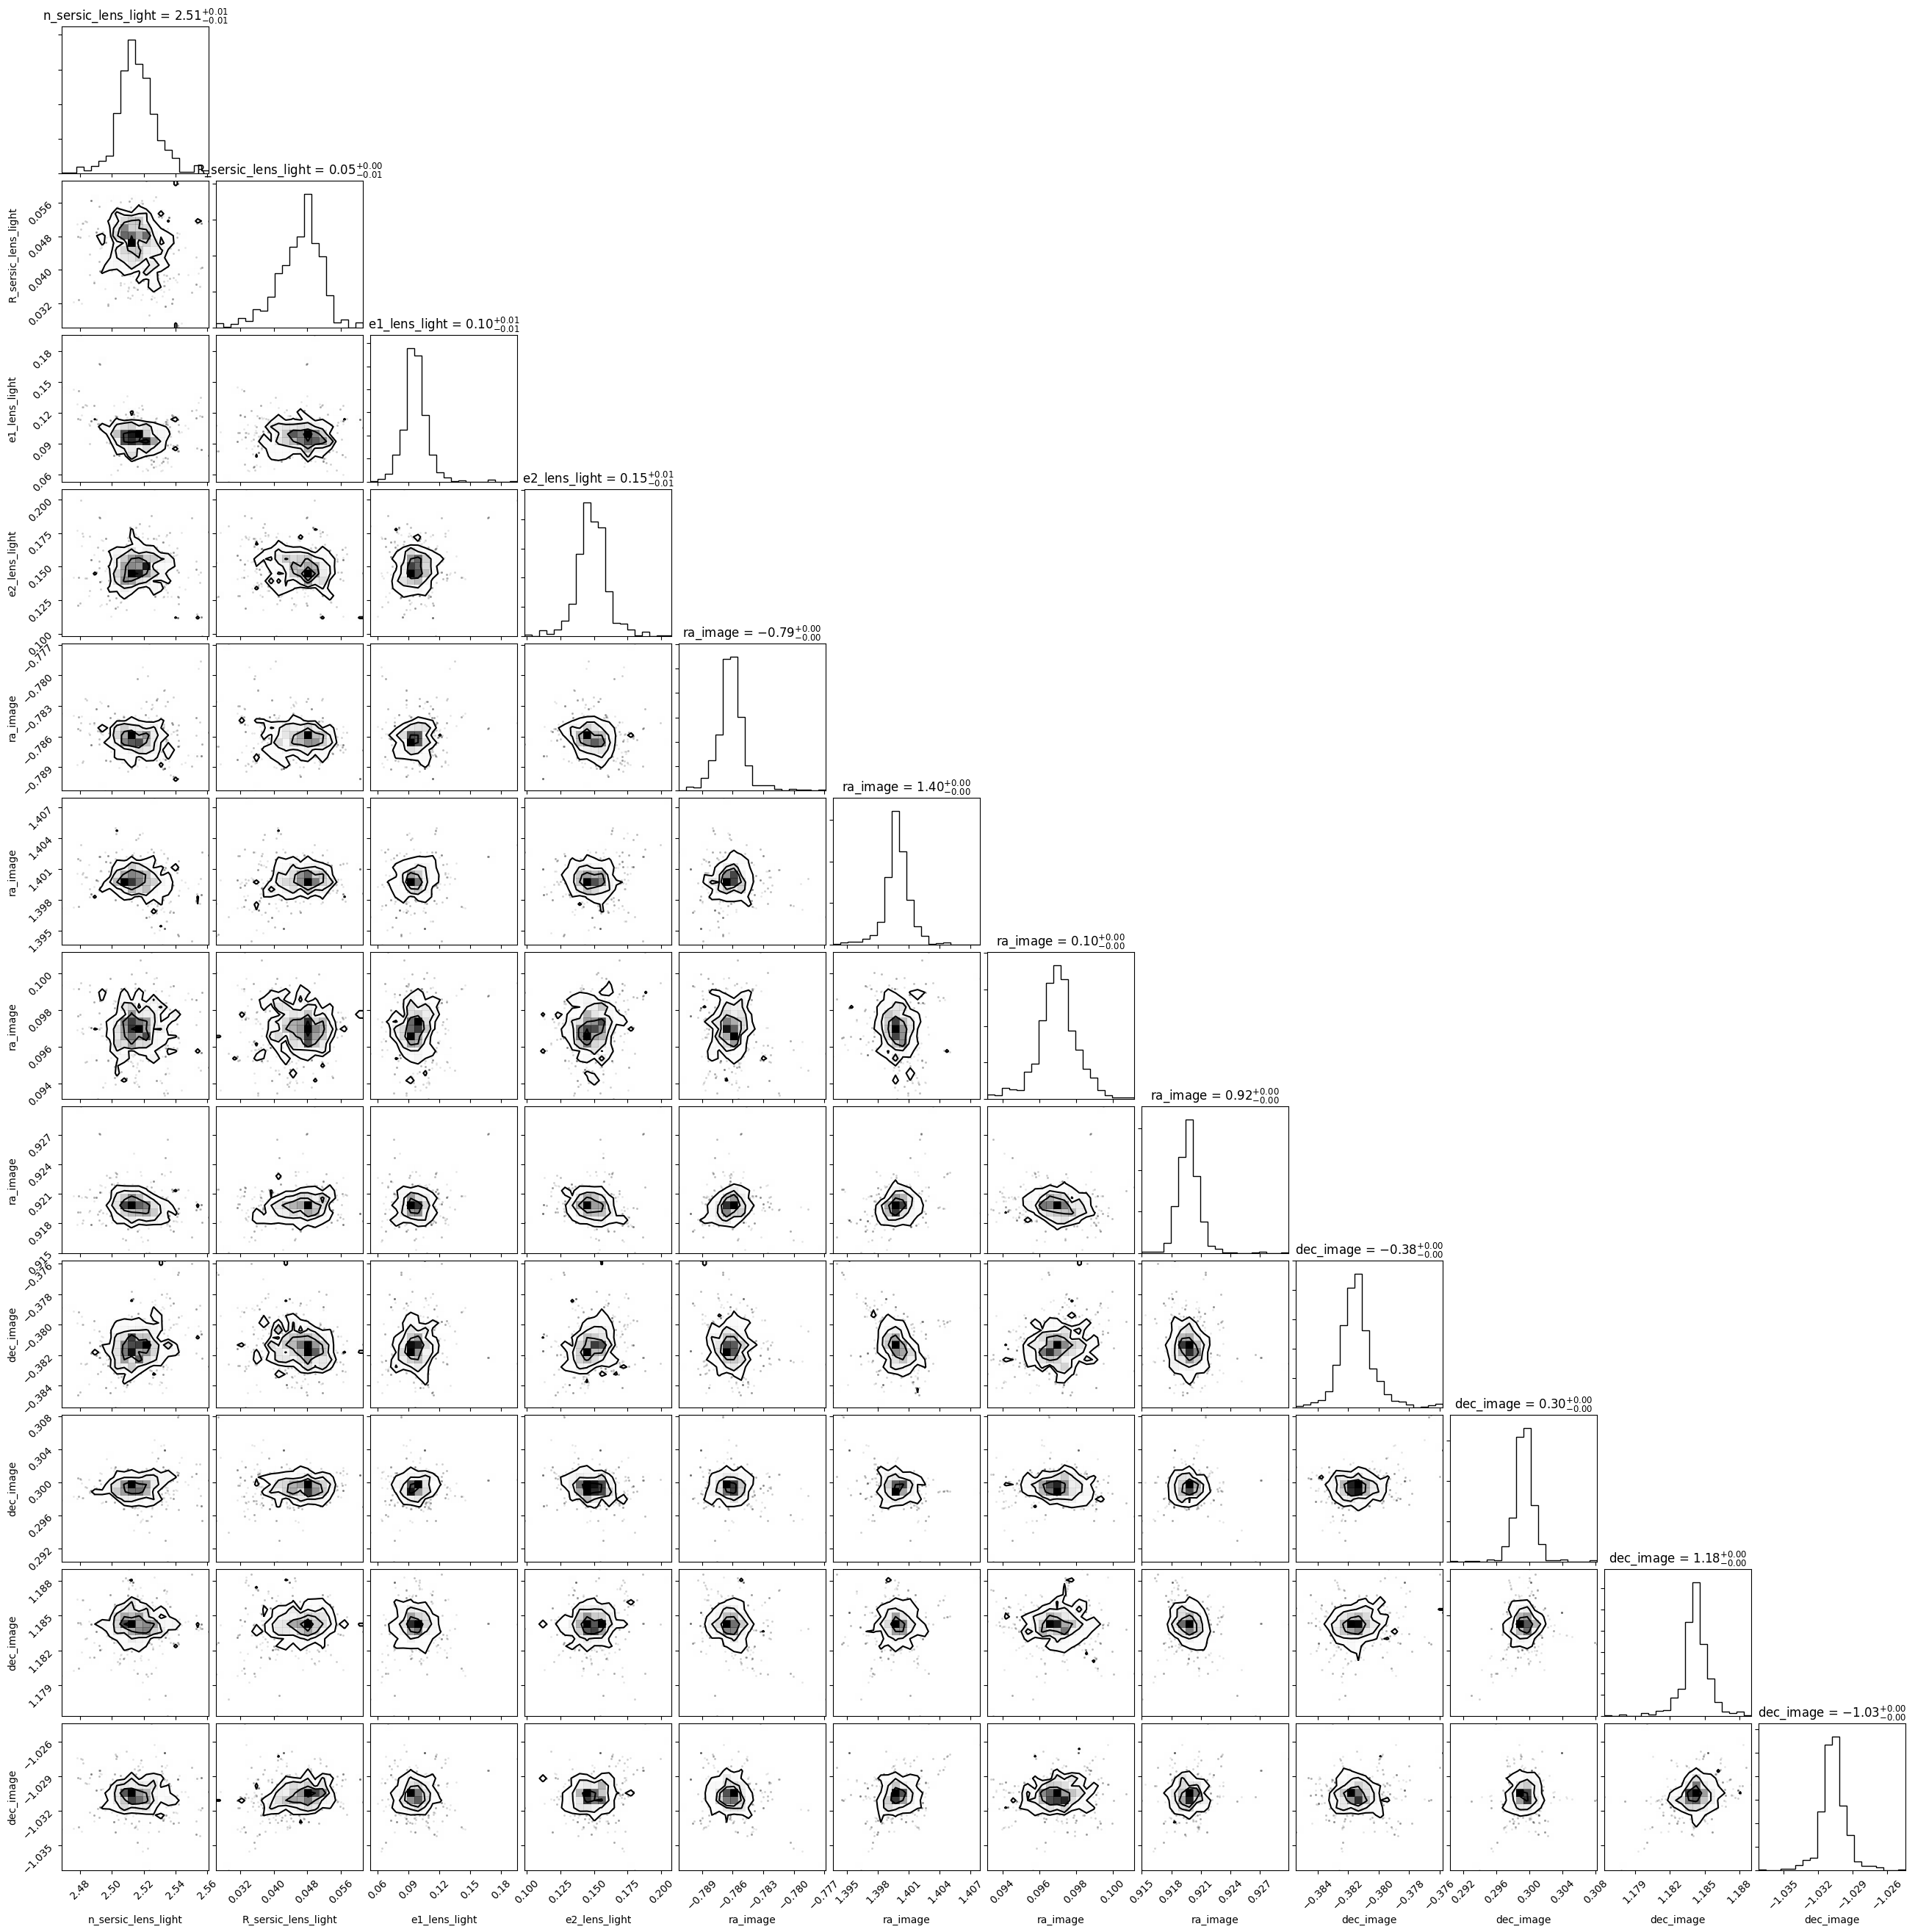

In [15]:
print "number of non-linear parameters in the MCMC process: ", len(param_mcmc)
print "parameters in order: ", param_mcmc
print "number of evaluations in the MCMC process: ", np.shape(samples_mcmc)[0]
import corner
if not samples_mcmc == []:
        n, num_param = np.shape(samples_mcmc)
        plot = corner.corner(samples_mcmc[:,:8], labels=param_mcmc[:8], show_titles=True)
        plot = corner.corner(samples_mcmc[:,8:], labels=param_mcmc[8:], show_titles=True)